In [1]:
!pip install spacy gensim pyLDAvis 

In [2]:
!pip install --user spacy  #in the terminal run: python -m spacy download en_core_web_sm

In [4]:
# General stuff
import re
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path
import json


#NLTK
import nltk
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gsf431/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words) #see the default list of stop words
stop_words.extend(['from', 'hath', 'doth', 'thou', 'use', 'thus', 'thy'])  #add your custom stop words
print(stop_words) #see the final list of stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
txt_folder = Path('data_folder/').rglob('*.txt') #gather the paths for all your text files, your data_folder needs to be in your working directory
files = [x for x in txt_folder] #create a list with all the file paths
files

[PosixPath('data_folder/060.txt'),
 PosixPath('data_folder/074.txt'),
 PosixPath('data_folder/048.txt'),
 PosixPath('data_folder/114.txt'),
 PosixPath('data_folder/100.txt'),
 PosixPath('data_folder/128.txt'),
 PosixPath('data_folder/129.txt'),
 PosixPath('data_folder/101.txt'),
 PosixPath('data_folder/115.txt'),
 PosixPath('data_folder/049.txt'),
 PosixPath('data_folder/075.txt'),
 PosixPath('data_folder/061.txt'),
 PosixPath('data_folder/088.txt'),
 PosixPath('data_folder/077.txt'),
 PosixPath('data_folder/063.txt'),
 PosixPath('data_folder/103.txt'),
 PosixPath('data_folder/117.txt'),
 PosixPath('data_folder/116.txt'),
 PosixPath('data_folder/102.txt'),
 PosixPath('data_folder/062.txt'),
 PosixPath('data_folder/076.txt'),
 PosixPath('data_folder/089.txt'),
 PosixPath('data_folder/099.txt'),
 PosixPath('data_folder/072.txt'),
 PosixPath('data_folder/066.txt'),
 PosixPath('data_folder/106.txt'),
 PosixPath('data_folder/112.txt'),
 PosixPath('data_folder/113.txt'),
 PosixPath('data_fol

In [8]:
#create a dictionary which contains all the file names and matches them to their text contents
papers={}
papers['target_names']=[]
papers['content']=[]
for name in files:
    f = open(name, 'r')
    print(str(name).split('/')[1])  #print(str(name).split('\\')[1])  use this code on windows
    papers['target_names'].append(str(name).split('/')[1])  #papers['target_names'].append(str(name).split('\\')[1]) use this code on windows
    papers['content'].append(' '.join(f.readlines()))
    f.close()

060.txt
074.txt
048.txt
114.txt
100.txt
128.txt
129.txt
101.txt
115.txt
049.txt
075.txt
061.txt
088.txt
077.txt
063.txt
103.txt
117.txt
116.txt
102.txt
062.txt
076.txt
089.txt
099.txt
072.txt
066.txt
106.txt
112.txt
113.txt
107.txt
067.txt
073.txt
098.txt
059.txt
065.txt
071.txt
139.txt
111.txt
105.txt
104.txt
110.txt
138.txt
070.txt
064.txt
058.txt
003.txt
017.txt
016.txt
002.txt
014.txt
028.txt
148.txt
149.txt
029.txt
001.txt
015.txt
039.txt
011.txt
005.txt
004.txt
010.txt
038.txt
006.txt
012.txt
013.txt
007.txt
022.txt
036.txt
142.txt
143.txt
037.txt
023.txt
035.txt
021.txt
009.txt
141.txt
154.txt
140.txt
008.txt
020.txt
034.txt
018.txt
030.txt
024.txt
144.txt
150.txt
151.txt
145.txt
025.txt
031.txt
019.txt
027.txt
033.txt
153.txt
147.txt
146.txt
152.txt
032.txt
026.txt
082.txt
096.txt
041.txt
055.txt
069.txt
135.txt
121.txt
109.txt
108.txt
120.txt
134.txt
068.txt
054.txt
040.txt
097.txt
083.txt
095.txt
081.txt
056.txt
042.txt
122.txt
136.txt
137.txt
123.txt
043.txt
057.txt
080.txt


In [9]:
#convert the dictionary to a pandas data frame so we can clean the content
df = pd.DataFrame.from_dict(papers)
df.head()

,target_names,content
0,060.txt,\n LX.\n \n Like as the waves make towards the...
1,074.txt,\n LXXIV.\n \n But be contented: when that fel...
2,048.txt,"\n XLVIII.\n \n How careful was I, when I took..."
3,114.txt,My most true mind thus makes mine eye untrue.\...
4,100.txt,But sweet or colour it had stol'n from thee.\n...


In [13]:
# Convert the text contents to a list
data = df.content.values.tolist()

#Remove roman numerals
data = [re.sub('[MDCLXVI]+(\.|\b\w\n)', ' ', sent) for sent in data]

#Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting  quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[0:5])

[' Like as the waves make towards the pebbled shore, So do our minutes hasten '
 'to their end; Each changing place with that which goes before, In sequent '
 'toil all forwards do contend. Nativity, once in the main of light, Crawls to '
 'maturity, wherewith being crownd, Crooked elipses gainst his glory fight, '
 'And Time that gave doth now his gift confound. Time doth transfix the '
 'flourish set on youth And delves the parallels in beautys brow, Feeds on the '
 'rarities of natures truth, And nothing stands but for his scythe to mow: And '
 'yet to times in hope my verse shall stand, Praising thy worth, despite his '
 'cruel hand. ',
 ' But be contented: when that fell arrest Without all bail shall carry me '
 'away, My life hath in this line some interest, Which for memorial still with '
 'thee shall stay. When thou reviewest this, thou dost review The very part '
 'was consecrate to thee: The earth can have but earth, which is his due; My '
 'spirit is thine, the better part o

In [14]:
#remove the punctuation and collect all the individual words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['like', 'as', 'the', 'waves', 'make', 'towards', 'the', 'pebbled', 'shore', 'so', 'do', 'our', 'minutes', 'hasten', 'to', 'their', 'end', 'each', 'changing', 'place', 'with', 'that', 'which', 'goes', 'before', 'in', 'sequent', 'toil', 'all', 'forwards', 'do', 'contend', 'nativity', 'once', 'in', 'the', 'main', 'of', 'light', 'crawls', 'to', 'maturity', 'wherewith', 'being', 'crownd', 'crooked', 'elipses', 'gainst', 'his', 'glory', 'fight', 'and', 'time', 'that', 'gave', 'doth', 'now', 'his', 'gift', 'confound', 'time', 'doth', 'transfix', 'the', 'flourish', 'set', 'on', 'youth', 'and', 'delves', 'the', 'parallels', 'in', 'beautys', 'brow', 'feeds', 'on', 'the', 'rarities', 'of', 'natures', 'truth', 'and', 'nothing', 'stands', 'but', 'for', 'his', 'scythe', 'to', 'mow', 'and', 'yet', 'to', 'times', 'in', 'hope', 'my', 'verse', 'shall', 'stand', 'praising', 'thy', 'worth', 'despite', 'his', 'cruel', 'hand']]


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10
                              ) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

for i in range(len(data_words_bigrams)):
    print(data_words_bigrams[i])

['like', 'waves', 'make', 'towards', 'pebbled', 'shore', 'minutes', 'hasten', 'end', 'changing', 'place', 'goes', 'sequent', 'toil', 'forwards', 'contend', 'nativity', 'main', 'light', 'crawls', 'maturity', 'wherewith', 'crownd', 'crooked', 'elipses', 'gainst', 'glory', 'fight', 'time', 'gave', 'gift', 'confound', 'time', 'transfix', 'flourish', 'set', 'youth', 'delves', 'parallels', 'beautys', 'brow', 'feeds', 'rarities', 'natures', 'truth', 'nothing', 'stands', 'scythe', 'mow', 'yet', 'times', 'hope', 'verse', 'shall', 'stand', 'praising', 'worth', 'despite', 'cruel', 'hand']
['contented', 'fell', 'arrest', 'without', 'bail', 'shall', 'carry', 'away', 'life', 'line', 'interest', 'memorial', 'still', 'thee', 'shall', 'stay', 'reviewest', 'dost', 'review', 'part', 'consecrate', 'thee', 'earth', 'earth', 'due', 'spirit', 'thine', 'better', 'part', 'hast', 'lost', 'dregs', 'life', 'prey', 'worms', 'body', 'dead', 'coward', 'conquest', 'wretchs', 'knife', 'base', 'thee', 'remembered', 'wo

In [19]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

#nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = data_words_bigrams
print(data_lemmatized[:2])

[['like', 'waves', 'make', 'towards', 'pebbled', 'shore', 'minutes', 'hasten', 'end', 'changing', 'place', 'goes', 'sequent', 'toil', 'forwards', 'contend', 'nativity', 'main', 'light', 'crawls', 'maturity', 'wherewith', 'crownd', 'crooked', 'elipses', 'gainst', 'glory', 'fight', 'time', 'gave', 'gift', 'confound', 'time', 'transfix', 'flourish', 'set', 'youth', 'delves', 'parallels', 'beautys', 'brow', 'feeds', 'rarities', 'natures', 'truth', 'nothing', 'stands', 'scythe', 'mow', 'yet', 'times', 'hope', 'verse', 'shall', 'stand', 'praising', 'worth', 'despite', 'cruel', 'hand'], ['contented', 'fell', 'arrest', 'without', 'bail', 'shall', 'carry', 'away', 'life', 'line', 'interest', 'memorial', 'still', 'thee', 'shall', 'stay', 'reviewest', 'dost', 'review', 'part', 'consecrate', 'thee', 'earth', 'earth', 'due', 'spirit', 'thine', 'better', 'part', 'hast', 'lost', 'dregs', 'life', 'prey', 'worms', 'body', 'dead', 'coward', 'conquest', 'wretchs', 'knife', 'base', 'thee', 'remembered', '

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [21]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[('beautys', 1),
  ('brow', 1),
  ('changing', 1),
  ('confound', 1),
  ('contend', 1),
  ('crawls', 1),
  ('crooked', 1),
  ('crownd', 1),
  ('cruel', 1),
  ('delves', 1),
  ('despite', 1),
  ('elipses', 1),
  ('end', 1),
  ('feeds', 1),
  ('fight', 1),
  ('flourish', 1),
  ('forwards', 1),
  ('gainst', 1),
  ('gave', 1),
  ('gift', 1),
  ('glory', 1),
  ('goes', 1),
  ('hand', 1),
  ('hasten', 1),
  ('hope', 1),
  ('light', 1),
  ('like', 1),
  ('main', 1),
  ('make', 1),
  ('maturity', 1),
  ('minutes', 1),
  ('mow', 1),
  ('nativity', 1),
  ('natures', 1),
  ('nothing', 1),
  ('parallels', 1),
  ('pebbled', 1),
  ('place', 1),
  ('praising', 1),
  ('rarities', 1),
  ('scythe', 1),
  ('sequent', 1),
  ('set', 1),
  ('shall', 1),
  ('shore', 1),
  ('stand', 1),
  ('stands', 1),
  ('time', 2),
  ('times', 1),
  ('toil', 1),
  ('towards', 1),
  ('transfix', 1),
  ('truth', 1),
  ('verse', 1),
  ('waves', 1),
  ('wherewith', 1),
  ('worth', 1),
  ('yet', 1),
  ('youth', 1)],
 [('shall'

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Ceiling for num of topics, model will evaluate up to but not including this number

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, workers=5, id2word=dictionary, random_state=5999, passes=10, alpha='asymmetric', decay=0.5, eta=None, eval_every=0, iterations=100, gamma_threshold=0.001, per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
set_limit = 31  #choose the max ceiling for number of topics, your model will have a max of one less than this ceiling
set_start = 2 #set the minium number of topics your model will run
set_step = 2 #set the step width for number of topics per model

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=set_start, limit=set_limit, step=set_step)

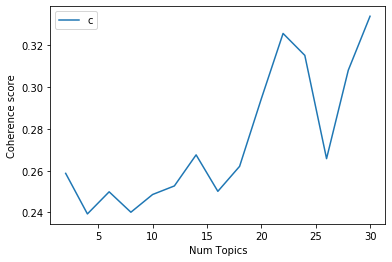

In [24]:
# Show graph

x = range(set_start, set_limit, set_step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2587
Num Topics = 4  has Coherence Value of 0.2393
Num Topics = 6  has Coherence Value of 0.2499
Num Topics = 8  has Coherence Value of 0.2401
Num Topics = 10  has Coherence Value of 0.2486
Num Topics = 12  has Coherence Value of 0.2527
Num Topics = 14  has Coherence Value of 0.2676
Num Topics = 16  has Coherence Value of 0.2501
Num Topics = 18  has Coherence Value of 0.2621
Num Topics = 20  has Coherence Value of 0.2944
Num Topics = 22  has Coherence Value of 0.3257
Num Topics = 24  has Coherence Value of 0.3152
Num Topics = 26  has Coherence Value of 0.2658
Num Topics = 28  has Coherence Value of 0.3081
Num Topics = 30  has Coherence Value of 0.3339


In [26]:
# Select the model and print the topics
optimal_model = model_list[10] #choose which model in the list you think is the best, remember python started indexing from 0
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))  #sets the number of words to show you per topics

[(21,
  '0.017*"mine" + 0.017*"love" + 0.010*"pity" + 0.010*"thee" + 0.010*"show" + '
  '0.008*"loves" + 0.007*"thence" + 0.007*"thine" + 0.007*"loving" + '
  '0.007*"may"'),
 (20,
  '0.018*"love" + 0.013*"thee" + 0.013*"time" + 0.010*"day" + 0.008*"night" + '
  '0.007*"make" + 0.007*"even" + 0.005*"muse" + 0.005*"shall" + 0.005*"never"'),
 (19,
  '0.015*"beauty" + 0.010*"second" + 0.010*"map" + 0.010*"dead" + '
  '0.005*"antique" + 0.005*"golden" + 0.005*"brow" + 0.005*"holy" + '
  '0.005*"lived" + 0.005*"days"'),
 (18,
  '0.010*"pride" + 0.010*"sweet" + 0.007*"wealth" + 0.007*"part" + '
  '0.007*"white" + 0.007*"breath" + 0.007*"garments" + 0.007*"birth" + '
  '0.007*"hawks" + 0.007*"wretched"'),
 (17,
  '0.000*"time" + 0.000*"thine" + 0.000*"thee" + 0.000*"whose" + 0.000*"face" '
  '+ 0.000*"glass" + 0.000*"tomb" + 0.000*"stop" + 0.000*"fair" + '
  '0.000*"tell"'),
 (16,
  '0.013*"love" + 0.011*"heart" + 0.010*"eyes" + 0.010*"fire" + 0.008*"beauty" '
  '+ 0.008*"see" + 0.008*"time" 

In [27]:

lda_final_model = gensim.models.LdaMulticore(corpus=corpus, num_topics=22, id2word=id2word, random_state=5999, passes=10, workers=5, alpha='asymmetric', decay=0.5, eta=None, eval_every=0, iterations=100, gamma_threshold=0.001, per_word_topics=True)  #now run just that model with the exact number of topics you want

In [28]:
# Show Topics
pprint(lda_final_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_final_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_score_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_score_lda)

[(21,
  [('mine', 0.016847726),
   ('love', 0.016528234),
   ('pity', 0.0097300885),
   ('thee', 0.009726558),
   ('show', 0.009717176),
   ('loves', 0.00832641),
   ('thence', 0.0073248586),
   ('thine', 0.0073218686),
   ('loving', 0.00732165),
   ('may', 0.0073186453)]),
 (20,
  [('love', 0.017771808),
   ('thee', 0.013280598),
   ('time', 0.012959348),
   ('day', 0.009743536),
   ('night', 0.008133121),
   ('make', 0.00670557),
   ('even', 0.0065192133),
   ('muse', 0.005478055),
   ('shall', 0.005223343),
   ('never', 0.0052178004)]),
 (19,
  [('beauty', 0.015465211),
   ('second', 0.010391037),
   ('map', 0.010388341),
   ('dead', 0.010377693),
   ('antique', 0.005315435),
   ('golden', 0.0053143594),
   ('brow', 0.005313366),
   ('holy', 0.0053133606),
   ('lived', 0.005313166),
   ('days', 0.005313043)]),
 (18,
  [('pride', 0.010233948),
   ('sweet', 0.010233946),
   ('wealth', 0.0068782265),
   ('part', 0.00687469),
   ('white', 0.0068734963),
   ('breath', 0.0068734963),
   (

In [30]:
# Visualize the topics
# Can't use the gensim method for MALLET directly so converting LdaMallet Model to LdaModel as per https://radimrehurek.com/gensim/models/wrappers/ldamallet.html
# Note that a "by hand" version of doing thing can be found at https://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/

#lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet, gamma_threshold=0.001, iterations=50)

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_final_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.105662  0.064126       1        1  10.624226
5     -0.101384 -0.047874       2        1   9.494872
15    -0.094498  0.010194       3        1   8.076543
2     -0.108063  0.009501       4        1   7.684350
7     -0.067355  0.087973       5        1   7.379541
8     -0.084528 -0.012790       6        1   6.187131
4     -0.056720 -0.003039       7        1   5.859515
16    -0.051108 -0.150417       8        1   5.405014
20    -0.020427  0.030023       9        1   5.358061
0     -0.016502 -0.014498      10        1   5.324317
1     -0.021124 -0.119095      11        1   5.010584
14     0.017110  0.077494      12        1   4.052937
9      0.024827  0.089277      13        1   3.263747
21     0.047738  0.029948      14        1   3.113953
12     0.046544  0.028201      15        1   2.529870
10     0.075576 -0.012672      16        1   2.148841
11     0.061828  0.034837      17        1   2.010327
13     0.066302 -0.036661      18        1   1.982791
6      0.093583  0.004596      19        1   1.959511
18     0.097114 -0.042186      20        1   1.801573
19     0.095253 -0.016874      21        1   0.689549
17     0.101497 -0.010063      22        1   0.042747, topic_info=       Term        Freq       Total Category  logprob  loglift
330  beauty   39.000000   39.000000  Default  30.0000  30.0000
93     thee  126.000000  126.000000  Default  29.0000  29.0000
754     one   33.000000   33.000000  Default  28.0000  28.0000
43    shall   45.000000   45.000000  Default  27.0000  27.0000
728   heart   38.000000   38.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
776    form    0.001305    9.219045  Topic22  -7.9801  -1.1053
184    self    0.001302   16.631865  Topic22  -7.9825  -1.6977
579    live    0.001302   23.060054  Topic22  -7.9825  -2.0246
434     age    0.001299   12.894186  Topic22  -7.9843  -1.4451
630    hate    0.001299   12.937624  Topic22  -7.9845  -1.4486

[1473 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2081      1  0.830827    abhor
1316      4  0.215770  absence
1316      7  0.431541  absence
1316      9  0.215770  absence
1316     11  0.215770  absence
...     ...       ...      ...
58        6  0.162776    youth
58        8  0.162776    youth
58       15  0.081388    youth
58       19  0.081388    youth
1411     18  0.806980   youths

[3043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 16, 3, 8, 9, 5, 17, 21, 1, 2, 15, 10, 22, 13, 11, 12, 14, 7, 19, 20, 18])

In [33]:
def format_topics_sentences(ldamodel=lda_final_model, corpus=corpus, texts=df):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = texts
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_final_model, corpus=corpus, texts=df)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'file_name','Text']

# Show
df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,file_name,Text
0,0,6.0,0.9844,"heart, time, make, sins, let, gainst, thee, cr...",060.txt,\n LX.\n \n Like as the waves make towards the...
1,1,3.0,0.9810,"thee, love, world, art, make, shall, see, upon...",074.txt,\n LXXIV.\n \n But be contented: when that fel...
2,2,1.0,0.9847,"heart, love, mine_eye, art, many, thee, eyes, ...",048.txt,"\n XLVIII.\n \n How careful was I, when I took..."
3,3,15.0,0.9838,"love, thee, time, shall, true, loves, sweet, t...",114.txt,My most true mind thus makes mine eye untrue.\...
4,4,15.0,0.9850,"love, thee, time, shall, true, loves, sweet, t...",100.txt,But sweet or colour it had stol'n from thee.\n...
...,...,...,...,...,...,...
149,149,11.0,0.9854,"love, thee, shall, excuse, slow, desire, swift...",051.txt,\n LI.\n \n Thus can my love excuse the slow o...
150,150,11.0,0.9828,"love, thee, shall, excuse, slow, desire, swift...",045.txt,"\n XLV.\n \n The other two, slight air and pur..."
151,151,12.0,0.9833,"thee, beauty, sweet, art, shall, fair, give, l...",079.txt,\n LXXIX.\n \n Whilst I alone did call upon th...
152,152,8.0,0.9826,"one, love, sweet, thee, every, fair, life, yet...",092.txt,\n XCII.\n \n But do thy worst to steal thysel...
